<a href="https://colab.research.google.com/github/Rick-Feng-u/nwHack2021_Stock_prediction_preoject/blob/programming/TensorflowStockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Prediction Using Tensorflow (RNN/LSTM)
- We will get Yahoo online up-to-date stock data for time series data analysis.
- The Tensorflow is configured to a specialied Reurrent Neural Network (RNN) called Long Short Term Memory (LSTM).
- An RNN is a type of neural network well-suited to time series data. 
- RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far.  

In [ ]:
# Test if Google cloud is ready for running.
print('Dan Lo')

Dan Lo


In [ ]:
# The first time to run the program, you need to install yfinance module and 
# yahoo_earings_calendar by running the folloiwng command once.
# After that, you can comment them out by prefixing a # sign. 
!pip install yfinance
!pip install yahoo_earnings_calendar

     |████████████████████████████████| 5.5MB 6.8MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=da96cfeabfe1110eec4a4e7fd2a15abb9d955fed8318fe2b69b0fcfe5e4e1e25
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
# Import required library modules
import yfinance as yf
from yahoo_earnings_calendar import YahooEarningsCalendar
import pandas as pd
import numpy as np

In [ ]:
# Try to get tickers from earnings report
# You may enter your prefered stock ticker manually.
yec= YahooEarningsCalendar()

In [ ]:
from datetime import datetime
day1 = datetime.strptime('10/30/2020', '%m/%d/%Y')
er = yec.earnings_on(day1)

In [ ]:
# Use this dropdown widget to select a ticker for retrieving the stock data.
from ipywidgets import Dropdown
option_list =[]
for i in range(len(er)):
  option_list.append([er[i]['companyshortname']+'-'+er[i]['ticker'], er[i]['ticker']])
dropdown = Dropdown(description = 'Select one company', options = option_list)
display(dropdown)
ticker = dropdown.value

Dropdown(description='Select one company', options=(['Phillips 66-PSX', 'PSX'], ['Phillips 66 Partners LP-PSXP…

In [ ]:
# Get the stock data from Yahoo finance.
# If your stock sticker is not found in the dropdown menu, just enter it here to replace 'ticker' variable.
data = yf.download(ticker,'2019-01-01','2020-05-22')

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Take a look at the data
data.head

<bound method NDFrame.head of                   Open        High  ...   Adj Close    Volume
Date                                ...                      
2019-01-02  134.130005  137.748993  ...  136.699997  16708400
2019-01-03  134.270004  134.869995  ...  130.600006  19531300
2019-01-04  134.259995  141.080002  ...  139.750000  22845400
2019-01-07  140.550003  144.080002  ...  143.100006  17239000
2019-01-08  145.000000  147.550003  ...  146.789993  16487600
...                ...         ...  ...         ...       ...
2020-05-15  200.699997  204.490005  ...  203.679993  17209500
2020-05-18  212.500000  215.470001  ...  215.279999  23646800
2020-05-19  216.729996  220.589996  ...  217.199997  21438100
2020-05-20  220.000000  221.156998  ...  216.789993  38324100
2020-05-21  211.289993  214.580002  ...  212.160004  29850700

[350 rows x 6 columns]>

In [ ]:
# Check the column headings
# We will use Adj Close for our training data.
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

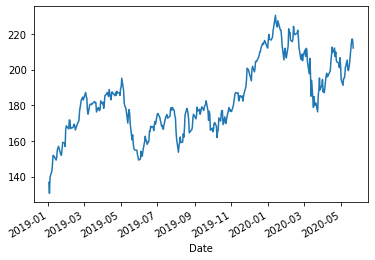

In [ ]:
# Slice out the Adj Close column for our study.
# Take a look at the data.
y = data['Adj Close']
y.index=data.index
y.plot()

In [ ]:
# Convert Pandas series to numpy ndarray for further processing.
y = y.values

In [ ]:
# Split data into trainning and testing using 80/20 ratio.
training_size = int(y.size * 0.8)
print(training_size)

280


In [ ]:
# Data normalization using training data's mean and standard deviation.
# y is a ndarray now and its dimension is 1.
training_mean = y[:training_size].mean()
training_std = y[:training_size].std()
# standarize the data
y = (y-training_mean)/training_std

In [ ]:
# Take a look at the training data
y[0:5]

array([-2.22724237, -2.54482223, -2.06845205, -1.89404286, -1.70193346])

In [ ]:
# Define a function to prepare data.
# The time series data are reorganized to form feature vectors and target values.
# For example, let sHistory be 10. A datapoint as a target will have 10 immediately 
# previous 10 values in the time series for its feature vector. 
def data_preprocess(dataset, iStart, iEnd, sHistory):
  data = []
  target = []
  # begin with sHistory to have historical data
  iStart += sHistory
  if iEnd is None:
    iEnd = len(dataset)
  for i in range(iStart, iEnd):
    indices = range(i-sHistory, i)
    data.append(np.reshape(dataset[indices], (sHistory, 1)))
    target.append(dataset[i])
  return np.array(data), np.array(target)

In [ ]:
# Let's define number of history data for training and split data into training nd testing datasets.
past_history = 10
xtrain, ytrain = data_preprocess(y, 0, training_size, past_history)
xtest, ytest = data_preprocess(y, training_size, None, past_history)

In [ ]:
# Take a look at data.
xtest[0]

array([[2.33394009],
       [2.12829397],
       [2.09028868],
       [2.13662414],
       [2.22096489],
       [2.00750894],
       [1.7237693 ],
       [1.38900877],
       [1.36037432],
       [1.52332973]])

In [ ]:
# Take a look at data.
xtest[1]

array([[2.12829397],
       [2.09028868],
       [2.13662414],
       [2.22096489],
       [2.00750894],
       [1.7237693 ],
       [1.38900877],
       [1.36037432],
       [1.52332973],
       [1.33017806]])

In [ ]:
# It's time to get Tensorflow library in and create an LSTM model.
import tensorflow as tf
# Setting seed to ensure reproducibility.
tf.random.set_seed(8888)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(8, input_shape=xtrain.shape[-2:]),
  tf.keras.layers.Dense(1)
])

In [ ]:
# Take a look at the model you have just created.
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Before taining, you need to configure the model for training.
model.compile(optimizer='Adam',
              loss='mse')

In [ ]:
BATCH_SIZE = 16
BUFFER_SIZE = 10000

p_train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
p_train = p_train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

p_test = tf.data.Dataset.from_tensor_slices((xtest, ytest))
p_test = p_test.batch(BATCH_SIZE).repeat()

In [ ]:
# For your model to be able to predict something, your need to train your model using training data.
history = model.fit(p_train, epochs = 10, steps_per_epoch=200, validation_data=p_test, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 1s 7ms/step - loss: 0.2225 - val_loss: 0.2510
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0686 - val_loss: 0.1806
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0513 - val_loss: 0.1771
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0469 - val_loss: 0.1630
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0442 - val_loss: 0.1526
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0419 - val_loss: 0.1418
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0390 - val_loss: 0.1326
Epoch 8/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0375 - val_loss: 0.1323
Epoch 9/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0351 - val_loss: 0.1226
Epoch 10/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0334 - val_loss: 0.1179

In [ ]:
# Convert training history to datafram for viewing and graphing.
hist = pd.DataFrame(history.history)
hist.head()

,loss,val_loss
0,0.222535,0.251041
1,0.068625,0.180593
2,0.051262,0.177073
3,0.046934,0.163023
4,0.044240,0.152586


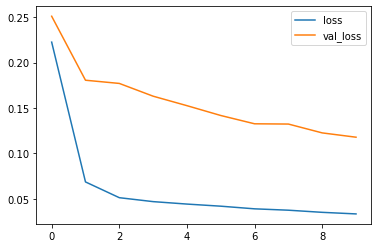

In [ ]:
# Training errors with respect to ecochs.
# loss: values of the cost function for training data.
# val_loss: values of the cost function for cross-validation data.
hist.plot()

In [ ]:
# Now, we can predict stock values after model is trained. 
# We keep the predicted values and target vlaues for graphics later.
# You may run on p_train or p_test to check the preformance.
predicted_value = []
y_orig = []
count =0;
for x, y in p_train.take(20):
  y_orig.append(y[0].numpy())
  t_pred= model.predict(x)
  predicted_value.append(t_pred[0])

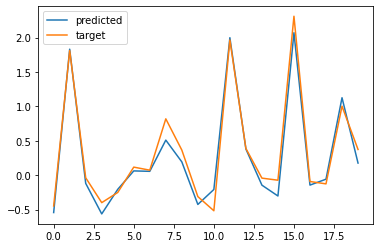

In [ ]:
# Plot the predicted value and the target values together.
y_pred = [predicted_value[i][0] for i in range(len(predicted_value))]
result = pd.DataFrame({'predicted':y_pred, 'target':y_orig})
result.plot()

# Thank you for watching. Please subscribe, thumb up, and share!

# If you like to watch something else, please give a comment. 